<a href="https://colab.research.google.com/github/hyson0427/CPSC585_AS3/blob/main/CPSC585_AS3_20240420.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The CUDA version is 12.1
ID of the CUDA device: 0
The name of the CUDA device: Tesla T4
GPU will be utilized for computation.
------------------ANN modeling---------------------------
> Shape of training data: torch.Size([60000, 28, 28])
> Shape of testing data: torch.Size([10000, 28, 28])
> Classes: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
> Mini batch size:  100
> Number of batches loaded for training:  600
> Number of batches loaded for testing:  100
> Shapes of image: torch.Size([100, 1, 28, 28])


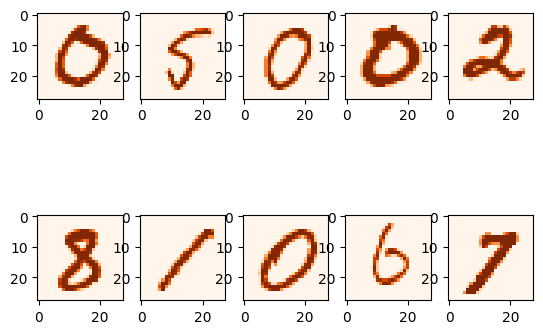

> MLP model parameters
<bound method Module.parameters of MLP(
  (hidden1): Linear(in_features=784, out_features=12, bias=True)
  (output): Linear(in_features=12, out_features=18, bias=True)
)>
> MLP model's state dictionary
hidden1.weight torch.Size([12, 784])
hidden1.bias torch.Size([12])
output.weight torch.Size([18, 12])
output.bias torch.Size([18])
output_size :  24.0 w :  12.0   num_flatten_nodes:  1440
> CNN model parameters
<bound method Module.parameters of CNN(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 10, kernel_size=(5, 5), stride=(1, 1))
  (drop2D): Dropout2d(p=0.25, inplace=False)
  (mp): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=160, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)>
...Modeling using GPU...
> MLP optimizer's state dictionary
state {}
param_groups [{'lr': 1.0, 'rho': 0.3, 'eps': 1e-06, 'weight_decay': 0, 'maximize

<ipython-input-6-c88f677ce865>:97: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return AF.log_softmax(x)


Epoch=1/1, batch=100/600, loss=0.2812919318675995
Epoch=1/1, batch=200/600, loss=0.19709546864032745
Epoch=1/1, batch=300/600, loss=0.12003348022699356
Epoch=1/1, batch=400/600, loss=0.12884946167469025
Epoch=1/1, batch=500/600, loss=0.06160662695765495
Epoch=1/1, batch=600/600, loss=0.08550801128149033
............Testing CNN model................
batch=100/100
> Number of samples= 100 number of correct prediction= 98 accuracy= 0.98


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch, torch.nn as nn, torch.optim as optim
import torch.nn.functional as AF
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

###################### Designing an ANN architectures #########################
### MLP architecture
class MLP(nn.Module): # All models should inherit from nn.Module
    # This part can be changed based on the design decision.
    def __init__(self, num_input, hidden1_size, num_classes): # Define our ANN structures here
        super(MLP, self).__init__()
        # nn.Linear(in_features, out_features, bias): y = w^Tx + bias
        self.hidden1 = nn.Linear(num_input, hidden1_size)    # connection between input and hidden layer1
        self.output = nn.Linear(hidden1_size, num_classes)

        # The model structure can be also defined using "sequential" function
        # self.seq_linear=nn.Sequential(nn.Linear(num_input, hidden1_size),nn.RELU(),nn.Linear(hidden1_size, num_classes))

    # Define "forward" function to perform the computation for input x and return output(s).
    # The function name "forward" is required by Pytorch.
    def forward(self, x):
        # In this implementation, the activation function is reLU, but you can try other functions
        # torch.nn.functional modeule consists of all the activation functions and output functions
        h1_out = AF.relu(self.hidden1(x)) # best activation function
        #h1_out = AF.sigmoid(self.hidden1(x))
        #h1_out = AF.tanh(self.hidden1(x))
        #h1_out = AF.softmax(self.hidden1(x))
        output = self.output(h1_out)
        # AF.softmax() is NOT needed when CrossEntropyLoss() is used as it already combines both LogSoftMax() and NLLLoss()

        # return self.seq_linear(x) # If the model structrue is define by sequential function.
        return output

### CNN architecture
class CNN(nn.Module):
    # The probability of dropout, number of hidden nodes, number of output classes
    def __init__(self, dropout_pr, num_hidden, num_classes):
        super(CNN, self).__init__()

        self.pool_size = 2
        self.filter_size = 5 # 1, 5 tested
        self.stride = 1
        self.output_size = ((28 - self.filter_size) / self.stride ) + 1
        self.w = ((self.output_size - self.pool_size) / self.pool_size) + 1
        self.num_flatten_nodes = int(num_classes * self.w * self.w)
        print('output_size : ', self.output_size, 'w : ', self.w, '  num_flatten_nodes: ', self.num_flatten_nodes)

        # convolutional layer = 1
        #self.conv1 = nn.Conv2d(1, num_classes, self.filter_size)
        #self.pool1 = nn.MaxPool2d(self.pool_size, self.pool_size)
        #self.dropout_conv1 = nn.Dropout2d(dropout_pr)
        #self.fc1 = nn.Linear(self.num_flatten_nodes, num_hidden)
        #self.out = nn.Linear(num_hidden, num_classes)

        # convolutional layer = 2
        self.conv1 = nn.Conv2d(1, 10, self.filter_size) # input_channel = 1, filter = 10
        # ((W-K+2P)/S + 1 ==> 24, by maxpooling it will be 12 * 12)
        # when pool size is 3, it will be 8*8
        self.conv2 = nn.Conv2d(10, 10, self.filter_size)
        # new w = 12
        # ((W-K+2P)/S + 1 ==> 8, by maxpooling it will be 4*4)

        self.drop2D = nn.Dropout2d(p=0.25, inplace=False)
        self.mp = nn.MaxPool2d(self.pool_size)
        #self.mp = nn.AvgPool2d(self.pool_size)
        #self.fc1 = nn.Linear(160, 10) # 4*4*10 Vector

        self.fc1 = nn.Linear(160, 100)
        self.fc2 = nn.Linear(100, 10) # to 10 outputs

    def forward(self, x):

      # convolutional layer = 1
      #x = AF.relu(self.pool1(self.conv1(x)))
      #x = AF.relu(self.dropout_conv1(x))
      #x = x.view(-1, self.num_flatten_nodes)
      #x = AF.relu(self.fc1(x))
      #x = AF.dropout(x)
      #x = self.out(x)
      #return x

      # convolutional layer = 2
      x = AF.relu(self.mp(self.conv1(x)))
      x = AF.relu(self.mp(self.conv2(x)))
      #x = AF.sigmoid(self.mp(self.conv1(x)))
      #x = AF.sigmoid(self.mp(self.conv2(x)))
      #x = AF.tanh(self.mp(self.conv1(x)))
      #x = AF.tanh(self.mp(self.conv2(x)))
      #x = AF.softmax(self.mp(self.conv1(x)))
      #x = AF.softmax(self.mp(self.conv2(x)))
      x = self.drop2D(x)
      x = x.view(x.size(0), -1)
      x = self.fc1(x)
      x = self.fc2(x)
      return AF.log_softmax(x)


# To display some images
def show_some_digit_images(images):
    print("> Shapes of image:", images.shape)
    #print("Matrix for one image:")
    #print(images[1][0])
    for i in range(0, 10):
        plt.subplot(2, 5, i+1) # Display each image at i+1 location in 2 rows and 5 columns (total 2*5=10 images)
        plt.imshow(images[i][0], cmap='Oranges') # show ith image from image matrices by color map='Oranges'
    plt.show()

# Training function
def train_ANN_model(num_epochs, training_data, device, CUDA_enabled, is_MLP, ANN_model, loss_func, optimizer):
    train_losses = []
    ANN_model.train() # to set the model in training mode. Only Dropout and BatchNorm care about this flag.
    for epoch_cnt in range(num_epochs):
        for batch_cnt, (images, labels) in enumerate(training_data):
            # Each batch contain batch_size (100) images, each of which 1 channel 28x28
            # print(images.shape) # the shape of images=[100,1,28,28]
            # So, we need to flatten the images into 28*28=784
            # -1 tells NumPy to flatten to 1D (784 pixels as input) for batch_size images
            if (is_MLP):
                # the size -1 is inferred from other dimensions
                images = images.reshape(-1, 784) # or images.view(-1, 784) or torch.flatten(images, start_dim=1)

            if (device.type == 'cuda' and CUDA_enabled):
                images = images.to(device) # moving tensors to device
                labels = labels.to(device)

            optimizer.zero_grad() # set the cumulated gradient to zero
            output = ANN_model(images) # feedforward images as input to the network
            loss = loss_func(output, labels) # computing loss
            #print("Loss: ", loss)
            #print("Loss item: ", loss.item())
            train_losses.append(loss.item())
            # PyTorch's Autograd engine (automatic differential (chain rule) package)
            loss.backward() # calculating gradients backward using Autograd
            optimizer.step() # updating all parameters after every iteration through backpropagation

            # Display the training status
            if (batch_cnt+1) % mini_batch_size == 0:
                print(f"Epoch={epoch_cnt+1}/{num_epochs}, batch={batch_cnt+1}/{num_train_batches}, loss={loss.item()}")
    return train_losses

# Testing function
def test_ANN_model(device, CUDA_enabled, is_MLP, ANN_model, testing_data):
    # torch.no_grad() is a decorator for the step method
    # making "require_grad" false since no need to keeping track of gradients
    predicted_digits=[]
    # torch.no_grad() deactivates Autogra engine (for weight updates). This help run faster
    with torch.no_grad():
        ANN_model.eval() # # set the model in testing mode. Only Dropout and BatchNorm care about this flag.
        for batch_cnt, (images, labels) in enumerate(testing_data):
            if (is_MLP):
                images = images.reshape(-1, 784) # or images.view(-1, 784) or torch.flatten(images, start_dim=1)

            if (device.type == 'cuda' and CUDA_enabled):
                images = images.to(device) # moving tensors to device
                labels = labels.to(device)

            output = ANN_model(images)
            _, prediction = torch.max(output,1) # returns the max value of all elements in the input tensor
            predicted_digits.append(prediction)
            num_samples = labels.shape[0]
            num_correct = (prediction==labels).sum().item()
            accuracy = num_correct/num_samples
            if (batch_cnt+1) % mini_batch_size == 0:
                print(f"batch={batch_cnt+1}/{num_test_batches}")
        print("> Number of samples=", num_samples, "number of correct prediction=", num_correct, "accuracy=", accuracy)
    return predicted_digits

########################### Checking GPU and setup #########################
### CUDA is a parallel computing platform and toolkit developed by NVIDIA.
# CUDA enables parallelize the computing intensive operations using GPUs.
# In order to use CUDA, your computer needs to have a CUDA supported GPU and install the CUDA Toolkit
# Steps to verify and setup Pytorch and CUDA Toolkit to utilize your GPU in your machine:
# (1) Check if your computer has a compatible GPU at https://developer.nvidia.com/cuda-gpus
# (2) If you have a GPU, continue to the next step, else you can only use CPU and ignore the rest steps.
# (3) Downloaded the compatible Pytorch version and CUDA version, refer to https://pytorch.org/get-started/locally/
# Note: If Pytorch and CUDA versions are not compatible, Pytorch will not be able to recognize your GPU
# (4) The following codes will verify if Pytorch is able to recognize the CUDA Toolkit:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
if (torch.cuda.is_available()):
    print("The CUDA version is", torch.version.cuda)
    # Device configuration: use GPU if available, or use CPU
    cuda_id = torch.cuda.current_device()
    print("ID of the CUDA device:", cuda_id)
    print("The name of the CUDA device:", torch.cuda.get_device_name(cuda_id))
    print("GPU will be utilized for computation.")
else:
    print("CUDA is supported in your machine. Only CPU will be used for computation.")
#exit()

############################### ANN modeling #################################
### Convert the image into numbers: transforms.ToTensor()
# It separate the image into three color channels RGB and converts the pixels of each images to the brightness
# of the color in the range [0,255] that are scaled down to a range [0,1]. The image is now a Torch Tensor (array object)
### Normalize the tensor: transforms.Normalize() normalizes the tensor with mean (0.5) and stdev (0.5)
#+ You can change the mean and stdev values
print("------------------ANN modeling---------------------------")
transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,)),])
# PyTorch tensors are like NumPy arrays that can run on GPU
# e.g., x = torch.randn(64,100).type(dtype) # need to cast tensor to a CUDA datatype (dtype)

from torch.autograd import Variable
x = Variable

### Download and load the dataset from the torch vision library to the directory specified by root=''
# MNIST is a collection of 7000 handwritten digits (in images) split into 60000 training images and 1000 for testing
# PyTorch library provides a clean data set. The following command will download training data in directory './data'
train_dataset=datasets.MNIST(root='./data', train=True, transform=transforms, download=True)
test_dataset=datasets.MNIST(root='./data', train=False, transform=transforms, download=False)
print("> Shape of training data:", train_dataset.data.shape)
print("> Shape of testing data:", test_dataset.data.shape)
print("> Classes:", train_dataset.classes)

# You can use random_split function to splite a dataset
#from torch.utils.data.dataset import random_split
#train_data, val_data, test_data = random_split(train_dataset, [60,20,20])

### DataLoader will shuffle the training dataset and load the training and test dataset
mini_batch_size = 100 #+ You can change this mini_batch_size
# If mini_batch_size==100, # of training batches=6000/100=600 batches, each batch contains 100 samples (images, labels)
# DataLoader will load the data set, shuffle it, and partition it into a set of samples specified by mini_batch_size.
train_dataloader=DataLoader(dataset=train_dataset, batch_size=mini_batch_size, shuffle=True)
test_dataloader=DataLoader(dataset=test_dataset, batch_size=mini_batch_size, shuffle=True)
num_train_batches = len(train_dataloader)
num_test_batches = len(test_dataloader)
print("> Mini batch size: ", mini_batch_size)
print("> Number of batches loaded for training: ", num_train_batches)
print("> Number of batches loaded for testing: ", num_test_batches)

### Let's display some images from the first batch to see what actual digit images look like
iterable_batches = iter(train_dataloader) # making a dataset iterable
images, labels = next(iterable_batches) # If you can call next() again, you get the next batch until no more batch left
show_digit_image = True
if show_digit_image:
    show_some_digit_images(images)

### Create an object for the ANN model defined in the MLP class
# Architectural parameters: You can change these parameters except for num_input and num_classes
num_input = 28*28   # 28X28=784 pixels of image
num_classes_mlp = 18    # output layer
num_hidden_mlp = 12     # number of neurons at the first hidden layer

num_classes_cnn = 10 # output layer of CNN model
num_hidden_cnn = 20 # number of neurons at the first hidden layer

# Randomly selected neurons by dropout_pr probability will be dropped (zeroed out) for regularization.
dropout_pr = 0.01


# MLP model
MLP_model=MLP(num_input, num_hidden_mlp, num_classes_mlp)
# Some model properties:
# .state_dic(): a dictionary of trainable parameters with their current valeus
# .parameter(): a list of all trainable parameters in the model
# .train() or .eval(): setting training, testing mode

print("> MLP model parameters")
print(MLP_model.parameters)
# state_dict() maps each layer to its parameter tensor.
print ("> MLP model's state dictionary")
for param_tensor in MLP_model.state_dict():
    print(param_tensor, MLP_model.state_dict()[param_tensor].size())

#exit()

# CNN model
CNN_model = CNN(dropout_pr, num_hidden_cnn, num_classes_cnn)
print("> CNN model parameters")
print(CNN_model.parameters)

# To turn on/off CUDA if I don't want to use it.
CUDA_enabled = True
if (device.type == 'cuda' and CUDA_enabled):
    print("...Modeling using GPU...")
    MLP_model = MLP_model.to(device=device) # sending to whaever device (for GPU acceleration)
    CNN_model = CNN_model.to(device=device)
else:
    print("...Modeling using CPU...")

### Define a loss function: You can choose other loss functions
loss_func = nn.CrossEntropyLoss() # for MLP
#loss_func_cnn = nn.CrossEntropyLoss() # for CNN
loss_func_cnn = nn.NLLLoss() # for CNN

### Choose a gradient method
# model hyperparameters and gradient methods
# optim.SGD performs gradient descent and update the weigths through backpropagation.
num_epochs = 1
alpha = 0.02       # learning rate for MLP
gamma = 0.3       # momentum for MLP

gamma_cnn = 0.3       # momentum for CNN

# Stochastic Gradient Descent (SGD) is used in this program.
#+ You can choose other gradient methods (Adagrad, adadelta, Adam, etc.) and parameters
#MLP_optimizer = optim.SGD(MLP_model.parameters(), lr=alpha, momentum=gamma)
#MLP_optimizer = optim.Adagrad(MLP_model.parameters(), lr=alpha)
MLP_optimizer = optim.Adadelta(MLP_model.parameters(), rho = gamma, eps = 1e-6)
#MLP_optimizer = optim.RMSprop(MLP_model.parameters(), lr=alpha, alpha=0.99, eps=1e-8)
#MLP_optimizer = optim.Adam(MLP_model.parameters(), lr=alpha)
print("> MLP optimizer's state dictionary")
for var_name in MLP_optimizer.state_dict():
    print(var_name, MLP_optimizer.state_dict()[var_name])

# CNN optimizer
#CNN_optimizer = optim.SGD(CNN_model.parameters(), lr=alpha, momentum=gamma)
CNN_optimizer = optim.Adagrad(CNN_model.parameters(), lr=alpha)
#CNN_optimizer = optim.Adadelta(CNN_model.parameters(), rho = gamma_cnn, eps = 1e-6)
#CNN_optimizer = optim.RMSprop(CNN_model.parameters(), lr=alpha, alpha=0.99, eps=1e-8)
#CNN_optimizer = optim.Adam(CNN_model.parameters(), lr=alpha)

### Train your networks
print("............Training MLP................")
is_MLP = True
train_loss=train_ANN_model(num_epochs, train_dataloader, device, CUDA_enabled, is_MLP, MLP_model, loss_func, MLP_optimizer)
print("............Testing MLP model................")
print("> Input digits:")
print(labels)
predicted_digits=test_ANN_model(device, CUDA_enabled, is_MLP, MLP_model, test_dataloader)
#print("> Predicted digits by MLP model")
#print(predicted_digits)

print("............Training CNN................")
is_MLP = False
train_loss=train_ANN_model(num_epochs, train_dataloader, device, CUDA_enabled, is_MLP, CNN_model, loss_func_cnn, CNN_optimizer)
print("............Testing CNN model................")
predicted_digits=test_ANN_model(device, CUDA_enabled, is_MLP, CNN_model, test_dataloader)

#print("> Predicted digits by CNN model")
#print(predicted_digits)

#### To save and load models and model's parameters ####
# To save and load model parameters
#print("...Saving and loading model states and model parameters...")
#torch.save(MLP_model.state_dict(), 'MLP_model_state_dict.pt')
#loaded_MLP_model=MLP(num_input, num_hidden, num_classes)
#loaded_MLP_model=MLP_model.load_state_dict(torch.load('MLP_model_state_dict.pt'))
#torch.save(MLP_optimizer.state_dict(), 'MLP_optimizer_state_dict.pt')
#loaded_MLP_optimizer = MLP_optimizer.load_state_dict(torch.load('MLP_optimizer_state_dict.pt'))

# To save and load a model
#print("...Saving model...")
#torch.save(MLP_model, 'MLP_model_NNIST.pt')
#pretrained_model = torch.load('MLP_model_NNIST.pt')
